<b><u>Observations</b></u>
<p>1. My data is skewed towards cities in the northern hemisphere (i.e., positive latitudes).  This isn't unusual since the vast majority of the global population is above the equater, but it's clear that there are way more dots on the right hand side of each chart than the left hand side.</p>
<p>2. In looking around +50 degrees latitude, there is a cluster of cities with ~70-90% humidity.  Outside of that, humidity levels were fairly dispersed across cities.</p>
<p>3. The trend for humidity described above is also similar for wind speed.  There is a bunch of of cities around +50 degrees latitude that have a wind speed between 0-10 mph.  There doesn't seem to be an obvious pattern for cities below +50 degrees latitude.</p>

I'm curious to see what trends would emerge if I used a much larger sample size or if I ran this script a few dozen times and compared the results.</p>

In [1]:
# Dependencies
import numpy as np
import random
import json
import requests
from pprint import pprint
from config import api_key
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Wrapper for OpenWeatherMap
# Will use this to view sample JSON API response
import openweathermapy.core as owm

# Dependencies for downloading and uncompressing list of cities from OpenWeatherMap
import urllib.request
import gzip

# Set the seaborn chart style
sns.set()

# Increase the size of the scatter plots
plt.rcParams["figure.figsize"] = [10,8]

In [2]:
# Print out a sample JSON API response
settings = {"units": "imperial", "appid": api_key}
pprint(owm.get_current(2172797, **settings))

{'base': 'stations',
 'clouds': {'all': 75},
 'cod': 200,
 'coord': {'lat': -16.92, 'lon': 145.77},
 'dt': 1522018800,
 'id': 2172797,
 'main': {'humidity': 88,
          'pressure': 1005,
          'temp': 78.8,
          'temp_max': 78.8,
          'temp_min': 78.8},
 'name': 'Cairns',
 'sys': {'country': 'AU',
         'id': 8166,
         'message': 0.0035,
         'sunrise': 1521922906,
         'sunset': 1521966203,
         'type': 1},
 'visibility': 10000,
 'weather': [{'description': 'shower rain',
              'icon': '09n',
              'id': 521,
              'main': 'Rain'}],
 'wind': {'deg': 160, 'speed': 8.05}}


<h1>Download City List</h1>

In [3]:
# This section downloads the list of cities and IDs that OpenWeatherMap uses from their website
# Decided this was more efficient than creating a list of cities using citipy and 
#   latitudes/longitudes since OpenWeatherMap says results will be more accurate if you use IDs instead of names

# File names
city_index_zip_file = "city.list.json.gz"
city_index_json_file = 'city.list.json'

# Download file
urllib.request.urlretrieve ("http://bulk.openweathermap.org/sample/city.list.json.gz", city_index_zip_file)

# Uncompress gzip file to json
inF = gzip.open(city_index_zip_file, 'rb')
outF = open(city_index_json_file, 'wb')
outF.write(inF.read())
inF.close()
outF.close()

# Read json file into a dataframe
city_index_df = pd.read_json(city_index_json_file)

# Print top five rows
city_index_df.head()

,coord,country,id,name
0,"{'lon': 34.283333, 'lat': 44.549999}",UA,707860,Hurzuf
1,"{'lon': 37.666668, 'lat': 55.683334}",RU,519188,Novinki
2,"{'lon': 84.633331, 'lat': 28}",NP,1283378,GorkhÄ�
3,"{'lon': 76, 'lat': 29}",IN,1270260,State of HaryÄ�na
4,"{'lon': 33.900002, 'lat': 44.599998}",UA,708546,Holubynka


<h1>Generate City List</h1>

In [4]:
# This section selects 555 random cities from the above city index dataframe

# Start by creating an empty dataframe
random_city_df = pd.DataFrame(columns=['coord', 'country', 'id', 'name', 'lon', 'lat'])

# Set counter to zero for looping
counter = 0

# Set total number of random cities
total_cities = 555

# Loop while counter is less than number of cities
while counter < total_cities:
    
    # Pick a random row (must be length - 1 since row starts at 0)
    row = random.randint(0, len(city_index_df)-1)
    
    # If ID is already in the dataframe then do nothing and repeat loop
    if any(random_city_df.id == city_index_df['id'][row]):
        pass
    
    # If ID isn't in the dataframe then add that row to the dataframe, including latitude and longitude
    else:
        random_city_df.loc[counter] = city_index_df.iloc[row,:]
        random_city_df.lat[counter] = city_index_df['coord'][row]['lat']
        random_city_df.lon[counter] = city_index_df['coord'][row]['lon']
        counter = counter + 1
        
# Change latitude and longitude columns from object to float
random_city_df[['lat','lon']] = random_city_df[['lat','lon']].apply(pd.to_numeric)

<h1>Weather API Call</h1>

In [5]:
# This section does the API calls from OpenWeatherMap

# Create empty lists for temperature, humidity, cloudiness and windspeed
# This will get added to the dataframe of cities
city_temp_list = []
city_humidity_list = []
city_cloudiness_list = []
city_windspeed_list = []

# Loop through the total number of cities
for index in range(total_cities):
    
    # Print out 
    print(f"Request {index+1} of {total_cities}: {random_city_df['name'][index]}")
    
    # Create the URL
    url = "http://api.openweathermap.org/data/2.5/weather?APPID="+api_key+"&units=imperial&id="+str(random_city_df.id[index])
    
    # Print the URl but mask the api key
    print("http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id="+str(random_city_df.id[index]))

    # Do the API call
    response = requests.get(url)
    
    # Convert API response to JSON
    data = response.json()
    
    # Grab temperature, humidity, cloudiness and windspeed and add it to their respective list    
    city_temp_list.append(data['main']['temp'])
    city_humidity_list.append(data['main']['humidity'])
    city_cloudiness_list.append(data['clouds']['all'])
    city_windspeed_list.append(data['wind']['speed'])

# Add temperature, humidity, cloudiness and windspeed as a column in the dataframe
random_city_df['temp'] = city_temp_list
random_city_df['humidity'] = city_humidity_list
random_city_df['cloudiness'] = city_cloudiness_list
random_city_df['windspeed'] = city_windspeed_list

Request 1 of 555: Tembalang
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=7035295
Request 2 of 555: Farvagny-le-Grand
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=2660818
Request 3 of 555: Feusisberg
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=7285816
Request 4 of 555: La Playona
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=3607146
Request 5 of 555: Naples Park
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=4165576
Request 6 of 555: Rollingwood
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=5388611
Request 7 of 555: Saint-Joseph-de-RiviÃ¨re
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=6433355
Request 8 of 555: Lieboch
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=7873406
Request 9 of 555: Weitersbach
http://api.openweathermap.org/data/2.5/

Request 73 of 555: Lengronne
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=3003119
Request 74 of 555: Copanatoyac
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=3530254
Request 75 of 555: Luis Moya
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=3997017
Request 76 of 555: Tschernitz
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=2820624
Request 77 of 555: Margate City
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=4502904
Request 78 of 555: Saint-Jean-de-Gonville
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=2979326
Request 79 of 555: Bickley
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=2076674
Request 80 of 555: Luzzi
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=6537671
Request 81 of 555: Quevedo
http://api.openweathermap.org/data/2.5/weather?A

Request 146 of 555: Zhaopu
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=6824158
Request 147 of 555: El Pescado
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=4008636
Request 148 of 555: West Pensacola
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=4177908
Request 149 of 555: Sankt Georgen am Walde
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=7871067
Request 150 of 555: Dinant
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=2799359
Request 151 of 555: Zolotnikovskaya Pustynâ€™
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=462197
Request 152 of 555: Carrick-on-Shannon
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=2965727
Request 153 of 555: PÃ´rto Novo
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=3452702
Request 154 of 555: Itzstedt
http://api.o

Request 217 of 555: San Julian
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=3985797
Request 218 of 555: Montalbo
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=2513667
Request 219 of 555: Cherokee
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=4851247
Request 220 of 555: Dimos Samos
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=8133749
Request 221 of 555: MaradÃ©kdÅ±lÅ‘
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=717844
Request 222 of 555: Aroma
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=378502
Request 223 of 555: Vrbas
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=3187297
Request 224 of 555: Herrera de los Navarros
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=6362814
Request 225 of 555: Emirdag
http://api.openweathermap.org/data/2.5/wea

Request 289 of 555: Obshtina Boboshevo
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=733152
Request 290 of 555: Teller
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=5875969
Request 291 of 555: Lincoln Park
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=4999311
Request 292 of 555: Benito
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=5898322
Request 293 of 555: Druya
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=628871
Request 294 of 555: Green Cove Springs
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=4157427
Request 295 of 555: Barpeta Road
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=7302849
Request 296 of 555: Goldswil
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=2660570
Request 297 of 555: Kutoanyar
http://api.openweathermap.org/data/2.5/

Request 361 of 555: Topolovo
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=726381
Request 362 of 555: Xinzhai
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=1788493
Request 363 of 555: Illar
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=2516456
Request 364 of 555: Sebina
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=933117
Request 365 of 555: Gerlafingen
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=7285905
Request 366 of 555: Gemeente Ommen
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=2749611
Request 367 of 555: Urexweiler
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=2818213
Request 368 of 555: Corrales
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=6362498
Request 369 of 555: Laiz
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&u

Request 432 of 555: Charleroi
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=2800481
Request 433 of 555: Reichelsheim
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=2849197
Request 434 of 555: Corrales de Duero
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=6362184
Request 435 of 555: Verkh-Chebula
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=1487599
Request 436 of 555: La Vale
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=4360113
Request 437 of 555: Tilichiki
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=2120591
Request 438 of 555: Olofstroem
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=2687062
Request 439 of 555: Calera de Leon
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=2520529
Request 440 of 555: Pomeroy
http://api.openweathermap.org/dat

Request 503 of 555: Hekinan
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=1862912
Request 504 of 555: Germagno
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=6535559
Request 505 of 555: Miengo
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=6360690
Request 506 of 555: Pedrajas de San Esteban
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=3114138
Request 507 of 555: Sheridan
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=4130821
Request 508 of 555: Breuil-le-Sec
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=3030205
Request 509 of 555: Mouilleron-en-Pareds
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=2991538
Request 510 of 555: Puspajati
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=7406786
Request 511 of 555: Falcade
http://api.openweathermap.org/

In [6]:
# Export city dataframe as CSV
random_city_df.to_csv("weather_data.csv", encoding='utf-8')

<h1>Print Charts</h1>

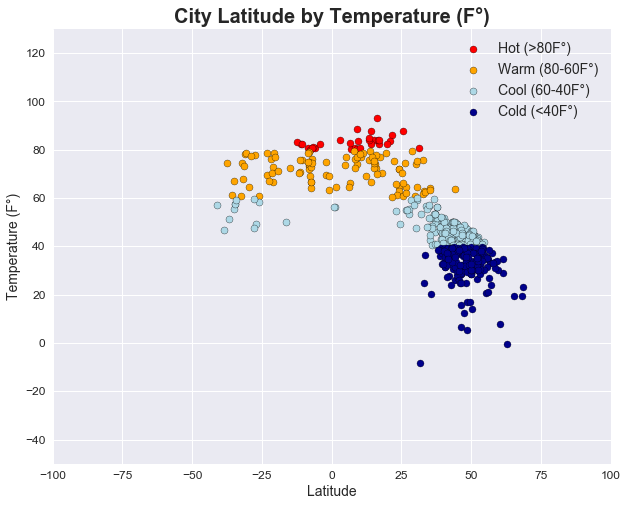

In [7]:
# This section prints a scatter plot of latitude by temperature

# Variables for hot, warm and cool cutoff tempatures
hot_temp = 80
warm_temp = 60
cold_temp = 40

# Create subsets of the dataframe to group by hot, warm, cool and cold temperatures
hot_cities = np.ma.masked_where((random_city_df['temp'] <= hot_temp), random_city_df['temp'])
warm_cities = np.ma.masked_where((random_city_df['temp'] > hot_temp) | (random_city_df['temp'] <= warm_temp), 
                                 random_city_df['temp'])
cool_cities = np.ma.masked_where((random_city_df['temp'] > warm_temp) | (random_city_df['temp'] <= cold_temp), random_city_df['temp'])
cold_cities = np.ma.masked_where((random_city_df['temp'] >= cold_temp), random_city_df['temp'])

# Clear the plot, just in case
plt.clf()

# Create scatter plots
plt.scatter(random_city_df['lat'], hot_cities, marker="o", facecolors='red', edgecolors="black", alpha=1)
plt.scatter(random_city_df['lat'], warm_cities, marker="o", facecolors='orange', edgecolors="black", alpha=1)
plt.scatter(random_city_df['lat'], cool_cities, marker="o", facecolors='lightblue', edgecolors="black", alpha=1)
plt.scatter(random_city_df['lat'], cold_cities, marker="o", facecolors='darkblue', edgecolors="black", alpha=1)

# Create a title, x label, and y label
plt.title("City Latitude by Temperature (F\N{DEGREE SIGN})", fontsize=20, fontweight="bold")
plt.xlabel("Latitude", fontsize=14)
plt.ylabel("Temperature (F\N{DEGREE SIGN})", fontsize=14)

# Legend
plt.legend((f'Hot (>{hot_temp}F\N{DEGREE SIGN})',f'Warm ({hot_temp}-{warm_temp}F\N{DEGREE SIGN})', 
            f'Cool ({warm_temp}-{cold_temp}F\N{DEGREE SIGN})',f'Cold (<{cold_temp}F\N{DEGREE SIGN})'),loc='best', prop={'size': 14})

# Set size of x and y tick labels
plt.tick_params(labelsize=12)

# Set x and y limits
plt.xlim(-100,100)
plt.ylim(-50,130)

# Save the figure
plt.savefig("LatByTemp.png")

# Display scatter chart
plt.show()

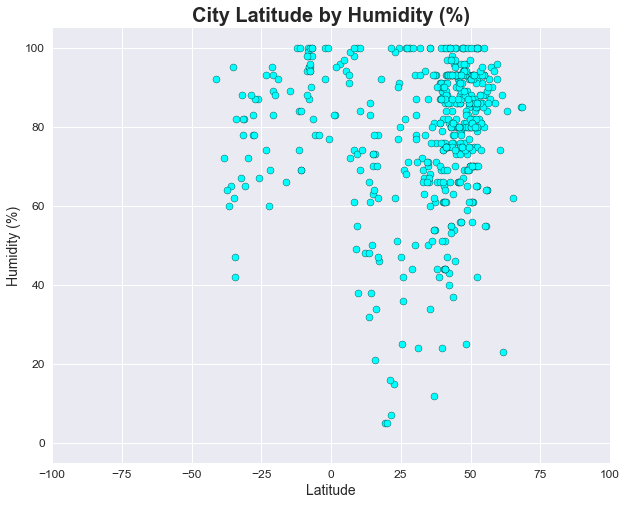

In [8]:
# This section prints a scatter plot of latitude by humidity

# Clear plot, just in case
plt.clf()

# Create scatter plot
plt.scatter(random_city_df['lat'], random_city_df['humidity'], marker="o", facecolors='aqua', edgecolors="black", alpha=1)

# Create a title, x label, and y label
plt.title("City Latitude by Humidity (%)", fontsize=20, fontweight="bold")
plt.xlabel("Latitude", fontsize=14)
plt.ylabel("Humidity (%)", fontsize=14)

# Set size of x and y tick labels
plt.tick_params(labelsize=12)

# Set x and y limits
plt.xlim(-100,100)
plt.ylim(-5,105)

# Save the figure
plt.savefig("LatByHumidity.png")

# Display scatter chart
plt.show()

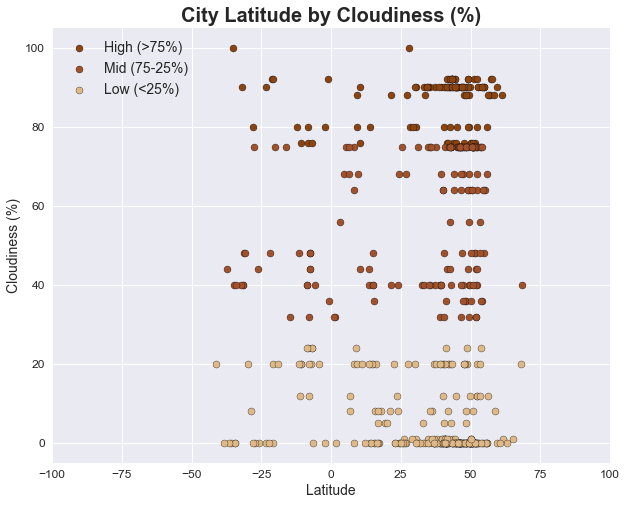

In [9]:
# This section prints a scatter plot of latitude by cloudiness

# Variables for high, mid and low cutoff levels of cloudiness
high_cloudiness = 75
low_cloudiness = 25

# Create subsets of the dataframe to group by migh, mid and low cloudiness
high_cloud_cities = np.ma.masked_where((random_city_df['cloudiness'] <= high_cloudiness), random_city_df['cloudiness'])
mid_cloud_cities = np.ma.masked_where((random_city_df['cloudiness'] > high_cloudiness) | 
                                      (random_city_df['cloudiness'] <= low_cloudiness), 
                                      random_city_df['cloudiness'])
low_cloud_cities = np.ma.masked_where((random_city_df['cloudiness'] >= low_cloudiness), random_city_df['cloudiness'])

# Clear plot, just in case
plt.clf()

# Create scatter plot
plt.scatter(random_city_df['lat'], high_cloud_cities, marker="o", facecolors='saddlebrown', edgecolors="black", alpha=1)
plt.scatter(random_city_df['lat'], mid_cloud_cities, marker="o", facecolors='sienna', edgecolors="black", alpha=1)
plt.scatter(random_city_df['lat'], low_cloud_cities, marker="o", facecolors='burlywood', edgecolors="black", alpha=1)

plt.legend((f'High (>{high_cloudiness}%)', f'Mid ({high_cloudiness}-{low_cloudiness}%)', 
            f'Low (<{low_cloudiness}%)'),loc='best', prop={'size': 14})

# Create a title, x label, and y label
plt.title("City Latitude by Cloudiness (%)", fontsize=20, fontweight="bold")
plt.xlabel("Latitude", fontsize=14)
plt.ylabel("Cloudiness (%)", fontsize=14)

# Set size of x and y tick labels
plt.tick_params(labelsize=12)

# Set x and y limits
plt.xlim(-100,100)
plt.ylim(-5,105)

# Save the figure
plt.savefig("LatByCloudiness.png")

# Display scatter plot
plt.show()

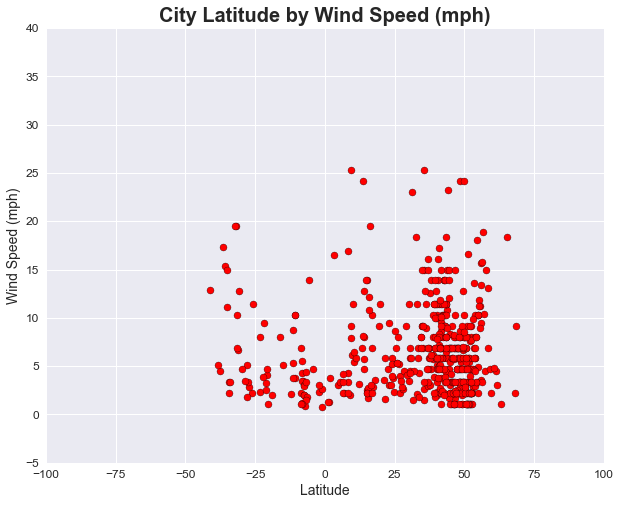

In [10]:
# This section prints a scatter plot of latitude by windspeed

# Clear plot, just in case
plt.clf()

# Create scatter plot
plt.scatter(random_city_df['lat'], random_city_df['windspeed'], marker="o", facecolors='red', edgecolors="black", alpha=1)

# Create a title, x label, and y label
plt.title("City Latitude by Wind Speed (mph)", fontsize=20, fontweight="bold")
plt.xlabel("Latitude", fontsize=14)
plt.ylabel("Wind Speed (mph)", fontsize=14)

# Set size of x and y tick labels
plt.tick_params(labelsize=12)

# Set x and y limits
plt.xlim(-100,100)
plt.ylim(-5,40)

# Save the figure
plt.savefig("LatByWindspeed.png")

# Display scatter plot
plt.show()